# Train xSiGra model

## Import required modules

In [1]:
import sys
sys.path.append('../xSiGra_model')
from utils import Cal_Spatial_Net
import warnings
warnings.filterwarnings('ignore')

In [3]:
import argparse
import os
import random
import time

import cv2
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torchvision.transforms as transforms
from sklearn.metrics.cluster import adjusted_rand_score
from train_transformer import test_nano_fov, train_nano_fov
from utils import Cal_Spatial_Net, Stats_Spatial_Net

# Set R path
os.environ["R_HOME"] = "/opt/R/4.0.2/lib/R"
os.environ["R_USER"] = "~/anaconda3/lib/python3.8/site-packages/rpy2"
os.environ["LD_LIBRARY_PATH"] = "/opt/R/4.0.2/lib/R/lib"
os.environ["PYTHONHASHSEED"] = "1234"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

## Set hyperparameters

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--root', type=str, default='../dataset/nanostring/lung13')
parser.add_argument('--epochs', type=int, default=200)
parser.add_argument('--id', type=str, default='fov1')
parser.add_argument('--img_name', type=str, default='F001')
parser.add_argument('--img_size', type=str, default='60,60')
parser.add_argument('--neurons', type=str, default='512,30')
parser.add_argument('--num_layers', type=str, default='2')
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument('--save_path', type=str, default='../checkpoint/nanostring_train_lung13_tutorial/')
parser.add_argument('--ncluster', type=int, default=8)
parser.add_argument('--repeat', type=int, default=0)
parser.add_argument('--use_gray', type=float, default=0)
parser.add_argument('--test_only', type=int, default=0)
parser.add_argument('--pretrain', type=str, default='final_100_0.pth')
parser.add_argument('--cluster_method', type=str, default='leiden')
parser.add_argument('--device', type=str, default='cuda:0')
parser.add_argument('--num_fov', type=str, default=20)
parser.add_argument('--dataset', type=str, default='lung13')
opt = parser.parse_args(args=[])

## Build spatial graph for fov

------Calculating spatial graph...
The graph contains 12930 edges, 3332 cells.
3.8806 neighbors per cell on average.


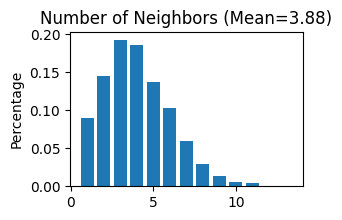

In [5]:
root = opt.root
img_name = 'F001'
id = 'fov1'
adata = sc.read(os.path.join(root, id, 'sampledata.h5ad'))
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

img = cv2.imread(os.path.join(root, id, 'CellComposite_%s.jpg'%(img_name)))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

if opt.use_gray:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
transform = transforms.ToTensor()
img = transform(img)

patchs = []

w, h = opt.img_size.split(",")
w = int(w)
h = int(h)

for coor in adata.obsm['spatial']:
    x, y = coor
    img_p = img[:, int(y-h):int(y+h), int(x-w): int(x+w)]
    patchs.append(img_p.flatten()) # 4 * h * w

patchs = np.stack(patchs)

df = pd.DataFrame(patchs, index=adata.obs.index)
adata.obsm['imgs'] = df

Cal_Spatial_Net(adata, rad_cutoff=80)
Stats_Spatial_Net(adata)

##  Set seed

In [6]:
seed = opt.seed
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Function to build spatial graph

In [7]:
def gen_adatas(root, id, img_name):
    adata = sc.read(os.path.join(root, id, 'sampledata.h5ad'))
    adata.var_names_make_unique()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    img = cv2.imread(os.path.join(root, id, 'CellComposite_%s.jpg'%(img_name)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if opt.use_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    transform = transforms.ToTensor()
    img = transform(img)

    patchs = []

    w, h = opt.img_size.split(",")
    w = int(w)
    h = int(h)
    
    for coor in adata.obsm['spatial']:
        x, y = coor
        img_p = img[:, int(y-h):int(y+h), int(x-w): int(x+w)]
        patchs.append(img_p.flatten()) # 4 * h * w

    patchs = np.stack(patchs)

    df = pd.DataFrame(patchs, index=adata.obs.index)
    adata.obsm['imgs'] = df

    Cal_Spatial_Net(adata, rad_cutoff=80)
    Stats_Spatial_Net(adata)
    return adata

## Build spatial graph for each fov

------Calculating spatial graph...
The graph contains 12930 edges, 3332 cells.
3.8806 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 18302 edges, 3971 cells.
4.6089 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 11910 edges, 3430 cells.
3.4723 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 9062 edges, 2963 cells.
3.0584 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 20582 edges, 4339 cells.
4.7435 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 12362 edges, 2999 cells.
4.1220 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 16246 edges, 3719 cells.
4.3684 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 14852 edges, 3666 cells.
4.0513 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 17390 edges

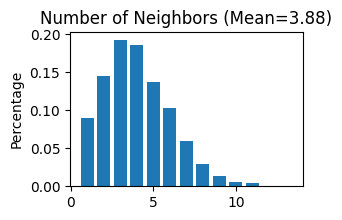

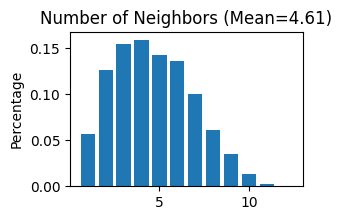

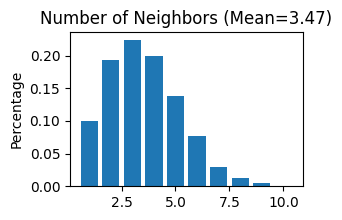

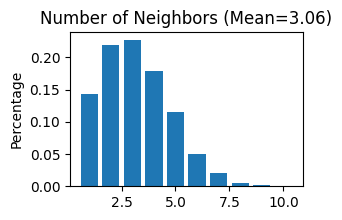

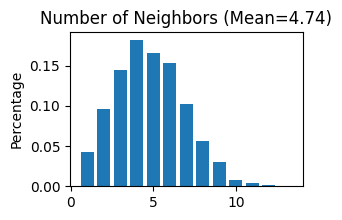

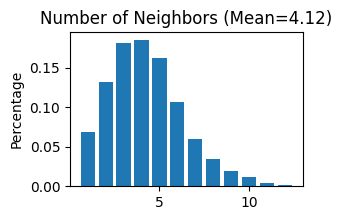

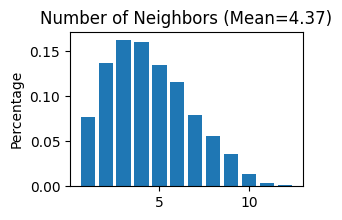

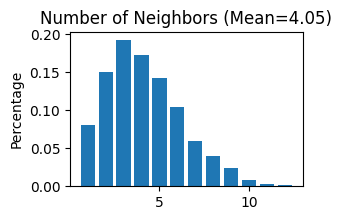

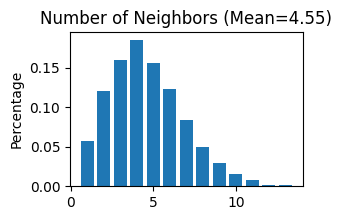

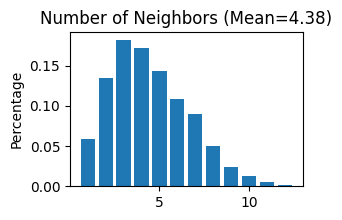

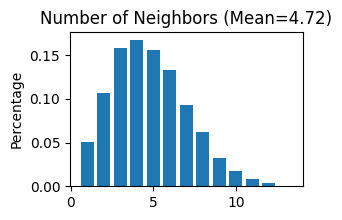

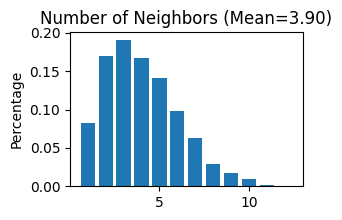

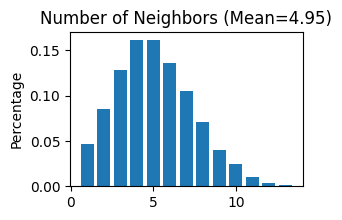

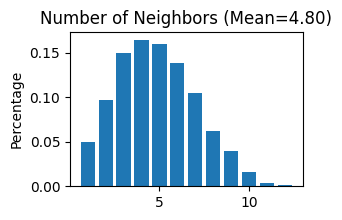

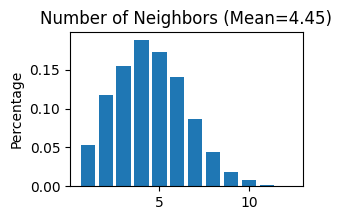

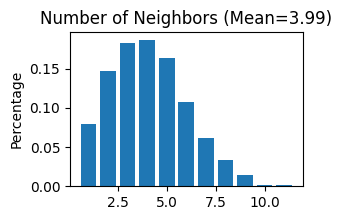

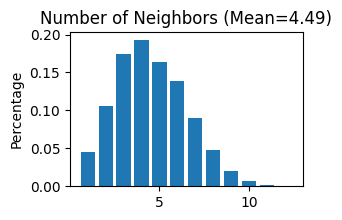

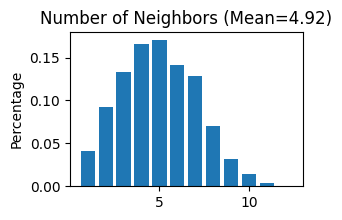

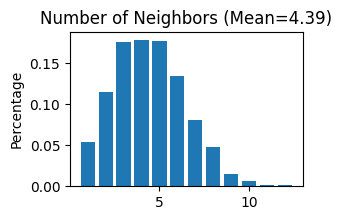

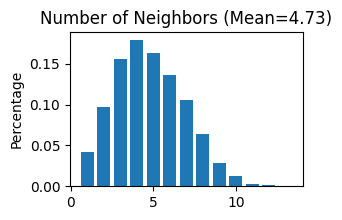

In [8]:
img_names =[]
ids = ['fov'+str(i) for i in range(1,int(opt.num_fov)+1)]
img_names = ['F00'+str(i) for i in range(1,10)]
img_names = img_names + ['F0'+str(i) for i in range(10,100)]
img_names = img_names + ['F'+str(i) for i in range(100,int(opt.num_fov)+1)]

adatas = list()
for id, name in zip(ids, img_names):
    adata = gen_adatas(opt.root, id, name)
    adatas.append(adata)

## Train model

In [9]:
sp = os.path.join(opt.save_path, 'all')
if not os.path.exists(sp):
    os.makedirs(sp)
    
import time
start_time = time.time()

train_nano_fov(
    opt,
    adatas,
    hidden_dims=opt.neurons,
    n_epochs=opt.epochs,
    lr=opt.lr,
    random_seed=opt.seed,
    save_path=sp,
    repeat=0,
)
end_time = time.time()
delta = end_time - start_time
sec = delta
hours = sec / (60 * 60)
print('difference in hours:', hours)

100%|██| 200/200 [24:21<00:00,  7.31s/it]


difference in hours: 0.8356716724236807


## Select best model

In [10]:
adata_pred = test_nano_fov(
    opt,
    adatas,
    hidden_dims=opt.neurons,
    random_seed=opt.seed,
    save_path=sp,
)

../checkpoint/nanostring_train_lung13_tutorial/all/final_191_0.pth


2023-10-14 22:13:07.782378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 22:13:08.136793: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


1.5
0.75
0.375
find 0.375
Davies_bouldin: 2.63
ARI: 0.51
ARI: 0.51
../checkpoint/nanostring_train_lung13_tutorial/all/final_192_0.pth
1.5
0.75
0.375
0.5625
0.46875
find 0.46875
Davies_bouldin: 2.50
ARI: 0.51
ARI: 0.51
../checkpoint/nanostring_train_lung13_tutorial/all/final_193_0.pth
1.5
0.75
0.375
0.5625
0.46875
0.421875
find 0.421875
Davies_bouldin: 2.34
ARI: 0.55
ARI: 0.55
../checkpoint/nanostring_train_lung13_tutorial/all/final_194_0.pth
1.5
0.75
0.375
0.5625
0.46875
0.421875
find 0.421875
Davies_bouldin: 2.34
ARI: 0.52
ARI: 0.52
../checkpoint/nanostring_train_lung13_tutorial/all/final_195_0.pth
1.5
0.75
0.375
find 0.375
Davies_bouldin: 2.31
ARI: 0.47
ARI: 0.47
../checkpoint/nanostring_train_lung13_tutorial/all/final_196_0.pth
1.5
0.75
0.375
0.5625
0.46875
find 0.46875
Davies_bouldin: 2.40
ARI: 0.52
../checkpoint/nanostring_train_lung13_tutorial/all/final_197_0.pth
1.5
0.75
0.375
find 0.375
Davies_bouldin: 2.32
ARI: 0.47
../checkpoint/nanostring_train_lung13_tutorial/all/final_198_

## Perform clustering

In [11]:
def res_search(adata_pred, ncluster, seed, iter=200):
    start = 0; end = 3
    i = 0
    while(start < end):
        if i >= iter: return res
        i += 1
        res = (start + end) / 2
        
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        sc.tl.leiden(adata_pred, random_state=seed, resolution=res)
        count = len(set(adata_pred.obs['leiden']))
        if count == ncluster:
            return res
        if count > ncluster:
            end = res
        else:
            start = res
    raise NotImplementedError()

res = res_search(adata_pred, opt.ncluster, opt.seed)
sc.tl.leiden(adata_pred, resolution=res, key_added='leiden', random_state=opt.seed)

## Calculate ARI

In [12]:
obs_df = adata_pred.obs.dropna()

ARI = adjusted_rand_score(obs_df['leiden'], obs_df['merge_cell_type'])
print('ARI: %.2f'%ARI)

ARI: 0.51


### The above steps can take significant time depending on the hardware and number of epochs to train the model. We have provided saved adata [lung13](https://drive.google.com/file/d/14FfrqmoFy4md84xentqd1wwsO7mQdj6C/view?usp=sharing) and checkpoints for quick test [here](https://drive.google.com/drive/folders/1L7N639ad4pvBHAUAs5zppdNoG4jZqXu4?usp=sharing)

## Download and use saved checkpoints to skip training

In [15]:
import time
start_time = time.time()
opt.save_path = "../checkpoint/nanostring_train_lung13/"
sp = "../checkpoint/nanostring_train_lung13/all/"

adata_pred = test_nano_fov(
    opt,
    adatas,
    hidden_dims=opt.neurons,
    random_seed=opt.seed,
    save_path=sp,
)
end_time = time.time()
delta = end_time - start_time
sec = delta
hours = sec / (60 * 60)
print('difference in hours:', hours)

../checkpoint/nanostring_train_lung13/all/final_191_0.pth
1.5
0.75
0.375
find 0.375
Davies_bouldin: 2.31
ARI: 0.47
ARI: 0.47
../checkpoint/nanostring_train_lung13/all/final_192_0.pth
1.5
0.75
0.375
0.5625
0.46875
0.421875
0.4453125
find 0.4453125
Davies_bouldin: 2.38
ARI: 0.56
../checkpoint/nanostring_train_lung13/all/final_193_0.pth
1.5
0.75
0.375
find 0.375
Davies_bouldin: 2.34
ARI: 0.47
../checkpoint/nanostring_train_lung13/all/final_194_0.pth
1.5
0.75
0.375
find 0.375
Davies_bouldin: 2.31
ARI: 0.47
../checkpoint/nanostring_train_lung13/all/final_195_0.pth
1.5
0.75
0.375
find 0.375
Davies_bouldin: 2.23
ARI: 0.53
ARI: 0.53
../checkpoint/nanostring_train_lung13/all/final_196_0.pth
1.5
0.75
0.375
find 0.375
Davies_bouldin: 2.33
ARI: 0.49
../checkpoint/nanostring_train_lung13/all/final_197_0.pth
1.5
0.75
0.375
find 0.375
Davies_bouldin: 2.35
ARI: 0.46
../checkpoint/nanostring_train_lung13/all/final_198_0.pth
1.5
0.75
0.375
find 0.375
Davies_bouldin: 2.30
ARI: 0.48
../checkpoint/nanostri

In [16]:
def res_search(adata_pred, ncluster, seed, iter=200):
    start = 0; end = 3
    i = 0
    while(start < end):
        if i >= iter: return res
        i += 1
        res = (start + end) / 2
        
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        sc.tl.leiden(adata_pred, random_state=seed, resolution=res)
        count = len(set(adata_pred.obs['leiden']))
        if count == ncluster:
            return res
        if count > ncluster:
            end = res
        else:
            start = res
    raise NotImplementedError()

res = res_search(adata_pred, opt.ncluster, opt.seed)
sc.tl.leiden(adata_pred, resolution=res, key_added='leiden', random_state=opt.seed)

In [17]:
obs_df = adata_pred.obs.dropna()

ARI = adjusted_rand_score(obs_df['leiden'], obs_df['merge_cell_type'])
print('ARI: %.2f'%ARI)

ARI: 0.53


## Use saved anndata for lung13 with best resolution for quick further processing

In [18]:
adata_pred = sc.read("../saved_adata/"+opt.dataset+"_adata_pred.h5ad")

In [19]:
if opt.dataset == "lung13":
    res = 0.3681250000000001
    
sc.tl.leiden(adata_pred, resolution=res, key_added='leiden', random_state=opt.seed)
obs_df = adata_pred.obs.dropna()

In [20]:
ARI = adjusted_rand_score(obs_df['leiden'], obs_df['merge_cell_type'])
print('ARI: %.2f'%ARI)

ARI: 0.63
